https://github.com/IcarusWizard/MAE

In [2]:
import torch
import torch.nn as nn
import numpy as np

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.vision_transformer import Block

In [3]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

import utils

In [317]:
class PatchShuffle(nn.Module):
    def __init__(self, mask_ratio):
        super().__init__()
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        b, n, d = x.shape
        len_keep = int(n * (1 - self.mask_ratio))
        noise = torch.rand(b, n, device=x.device)
        
        # Sort noise for each sample.
        ids_shuffle = torch.argsort(noise, dim=1)           # Ascend: small is keep, large is remove.
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        # Keep the first subset. 
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, d))
        
        # Generate the binary mask.
        loss_mask = torch.ones([b, n], device=x.device)
        loss_mask[:, :len_keep] = 0
        
        # Unshuffle to get the binary mask.
        loss_mask = torch.gather(loss_mask, dim=1, index=ids_restore)
        
        return x_masked, loss_mask, ids_restore
    
x = torch.randn(2, 256, 192)
mask_ratio = 0.75
x_masked, loss_mask, ids_restore = PatchShuffle(0.75)(x)
print(x_masked.shape)

torch.Size([2, 64, 192])


In [324]:
class Encoder(nn.Module):
    def __init__(self, emb_dim=192, img_size=32, in_channels=3, patch_size=2, mask_ratio=0.75, num_heads=3, depth=12):
        super().__init__()
        
        if emb_dim == None:
            emb_dim = in_channels * patch_size * patch_size
            
        self.patchify = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_emb = nn.Parameter(torch.zeros(1, (img_size // patch_size) **2 + 1, emb_dim))

        self.patch_shuffle = PatchShuffle(mask_ratio)
        
        self.transformer = nn.Sequential(
            *[Block(emb_dim, num_heads) for _ in range(depth)]
        )
        self.layer_norm = nn.LayerNorm(emb_dim)
        
        self.init_weight()
        
    def init_weight(self):
        nn.init.trunc_normal_(self.cls_token, std=.02)
        nn.init.trunc_normal_(self.pos_emb, std=.02)
        
    def forward(self, x):
        b, _, _, _ = x.shape
        
        x = self.patchify(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x += self.pos_emb[:, 1:, :]                           # Add position embedding.
        
        # Mask patches.
        x, loss_mask, ids_restore  = self.patch_shuffle(x)         
        
        # Append cls token.
        cls_token = self.cls_token + self.pos_emb[:, :1, :]
        cls_token = repeat(cls_token, '() n e -> b n e', b=b)
        x = torch.cat((cls_token, x), dim=1)
        
        # Apply transformer blocks.
        x = self.transformer(x)
        x = self.layer_norm(x)
        
        return x, loss_mask, ids_restore
    
x = torch.randn(2, 3, 32, 32)
x, loss_mask, ids_restore = Encoder()(x)       

print(x.shape)
print(loss_mask.shape)
print(ids_restore.shape)

torch.Size([2, 65, 192])
torch.Size([2, 256])
torch.Size([2, 256])


In [325]:
# mask = mask.unsqueeze(-1).repeat(1, 1, x.shape[2])
# print(mask.shape)

In [326]:
# print(mask)

In [327]:
class Decoder(nn.Module):
    def __init__(self, emb_dim=192, img_size=32, in_channels=3, patch_size=2, decoder_emb_dim=None, num_heads=3, depth=4):
        super().__init__()
        
        if decoder_emb_dim == None: decoder_emb_dim = emb_dim
        self.decoder_embed = nn.Linear(emb_dim, decoder_emb_dim)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_emb_dim))
        self.pos_emb = nn.Parameter(torch.zeros(1, (img_size // patch_size) **2 + 1, emb_dim))
        
        self.transformer = nn.Sequential(
            *[Block(decoder_emb_dim, num_heads) for _ in range(depth)]
        )
        
        self.layer_norm = nn.LayerNorm(decoder_emb_dim)
        self.head = torch.nn.Linear(decoder_emb_dim, patch_size ** 2 * in_channels)
        self.unpatchify = Rearrange('b (h w) (c p1 p2) -> b c (h p1) (w p2)' , p1=patch_size, p2=patch_size, c=in_channels, h=img_size//patch_size, w=img_size//patch_size)
        
    def init_weight(self):
        nn.init.trunc_normal_(self.mask_token, std=.02)
        nn.init.trunc_normal_(self.pos_emb, std=.02)
        
    def forward(self, x, ids_restore):
        # Embed tokens.
        x = self.decoder_embed(x)

#         print(self.mask_token.shape)
#         print(ids_restore.shape)
#         print(x.shape)
        # Append mask tokens to sequence.
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)            # No cls token.
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # Unshuffle.
        x = torch.cat([x[:, :1, :], x_], dim=1)    # Append cls token.

        x += self.pos_emb                          # Add pos embed.
        x = self.transformer(x)
        x = self.layer_norm(x)
        x = self.head(x)
        
        x = x [:, 1:, :]                          # Remove cls token
        x = self.unpatchify(x)
        return x
        
x_pred = Decoder()(x, ids_restore)
print(x_pred.shape)

torch.Size([2, 3, 32, 32])


In [328]:
# def __init__(self, emb_dim=192, img_size=32, in_channels=3, patch_size=2, mask_ratio=0.75, en_num_heads=3, en_depth=12):
# def __init__(self, emb_dim=192, img_size=32, in_channels=3, patch_size=2, decoder_emb_dim=None, num_heads=3, depth=4):

class MaskedAutoencoder(nn.Module):
    def __init__(self, emb_dim=192, img_size=32, in_channels=3, patch_size=2, 
                 mask_ratio=0.75, en_num_heads=3, en_depth=12, 
                 de_emb_dim=None, de_num_heads=3, de_depth=4, use_norm_pix_loss=True):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.mask_ratio = mask_ratio
        self.use_norm_pix_loss = use_norm_pix_loss
        self.flatten_patch = Rearrange('b c (h p1) (w p2) -> b (h w) (c p1 p2) ' , p1=patch_size, p2=patch_size, c=in_channels, h=img_size//patch_size, w=img_size//patch_size)
        
        self.encoder = Encoder(
            emb_dim=emb_dim, img_size=img_size, in_channels=in_channels, patch_size=patch_size, 
            mask_ratio=mask_ratio, num_heads=en_num_heads, depth=en_depth
        )
        
        self.decoder = Decoder(
            emb_dim=emb_dim, img_size=img_size, in_channels=in_channels, patch_size=patch_size, 
            decoder_emb_dim=de_emb_dim, num_heads=de_num_heads, depth=de_depth
        )
        
        
    def masked_loss(self, x, x_pred, loss_mask):
        """
        x_org: [b, c, h, w]
        x_pred: [b, c, h, w]
        loss_mask: [b, n]
        """
        loss_mask = loss_mask.unsqueeze(-1).repeat(1, 1, self.patch_size ** 2 * in_channels)
        loss_mask = rearrange(loss_mask, 'b (h w) (c p1 p2) -> b c (h p1) (w p2)' , 
                         p1=self.patch_size, p2=self.patch_size, c=self.in_channels, h=self.img_size//self.patch_size, w=self.img_size//self.patch_size)
        
        if self.use_norm_pix_loss:
            mean = x.mean(dim=-1, keepdim=True)
            var = x.var(dim=-1, keepdim=True)
            x = (x - mean) / (var + 1.e-6)**.5
            
        loss = torch.mean((x_pred - x) ** 2 * loss_mask) / self.mask_ratio
        return loss
    
    
    def forward(self, x):
        x, loss_mask, ids_restore = self.encoder(x)
        x_pred = self.decoder(x, ids_restore)
        return x_pred, loss_mask

    
    
x = torch.rand(1, 3, 32, 32)
MaskedAutoencoder().masked_loss(x, x_pred, mask)

tensor(1.2654, grad_fn=<DivBackward0>)

In [331]:
x = torch.rand(2, 3, 32, 32)
x_pred, loss_mask = MaskedAutoencoder()(x)
print(x_pred.shape)
print(loss_mask.shape)

torch.Size([2, 3, 32, 32])
torch.Size([2, 256])


In [252]:
num_epochs = 10
for epoch in range(num_epochs):
    

tensor(1.)

In [237]:
# emb_dim = 192
# patch_size = 2
# img_size = 32
# in_channels = 3


# def masked_loss(x_org, x_pred, mask):
#     """
#     x_org: [b, c, h, w]
#     x_pred: [b, c, h, w]
#     mask: [b, n], 0 is keep, 1 is remove.
#     """
    
#     mask = mask.unsqueeze(-1).repeat(1, 1, patch_size ** 2 * in_channels)
#     print(mask.shape)
#     mask = rearrange(mask, 'b (h w) (c p1 p2) -> b c (h p1) (w p2)' , p1=patch_size, p2=patch_size, c=in_channels, h=img_size//patch_size, w=img_size//patch_size)
#     print(mask.shape)
    
    
# masked_loss(x, x_pred, mask)

torch.Size([1, 256, 12])
torch.Size([1, 3, 32, 32])


In [233]:
x.shape[2]

192

In [206]:
mask.shape

torch.Size([1, 256])

In [ ]:
mask = rearrange('b n')

In [ ]:
b c

In [ ]:
b, h * w, p**2 * 3

In [192]:
x.shape

torch.Size([1, 3, 32, 32])

In [194]:
x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', p1=patch_size)
x.shape

EinopsError:  Error while processing rearrange-reduction pattern "b c (h p1) (w p2) -> b (h w) (c p1 p2)".
 Input tensor shape: torch.Size([1, 1024, 3]). Additional info: {}.
 Could not infer sizes for {'p1', 'h'}

In [181]:
x_pred.shape

torch.Size([1, 256, 12])

In [ ]:
mask = rearrange(mask, 'b')

In [151]:
mask

rearrange(x, 'b c h w -> b (h w) c')

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
         0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
         0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
         1., 1., 0., 1., 1.,

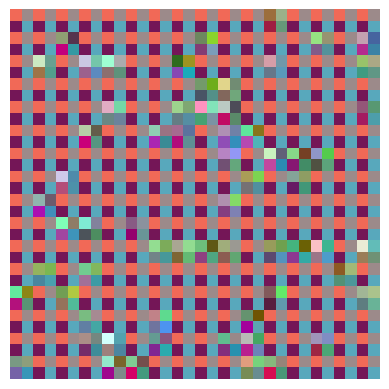

In [150]:
utils.show_img_tensor(pred_x[0])

In [ ]:
def MAE_loss(x, pred_x, mask):
    """
    x: [b, c, h, w]
    x_pred: [b, c, h, w]
    mask: [b, n]
    """
    x

In [34]:
x = torch.randn(1, 256, 192)
mask_ratio = 0.75



b, n, d= x.shape
len_keep = int(n * (1 - mask_ratio))

noise = torch.rand(b, n, device=x.device)
# Sort noise for each sample.
ids_shuffle = torch.argsort(noise, dim=1)           # Ascend: small is keep, large is remove.
ids_restore = torch.argsort(ids_shuffle, dim=1)
# print(ids_shuffle.shape)

# Keep the first subset. 
ids_keep = ids_shuffle[:, :len_keep]
# print(ids_keep.shape)
x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, d))
# print(x_masked.shape)

# Generate the binary mask: 0 is keep, 1 is remove.
mask = torch.ones([b, n], device=x.device)
mask[:, :len_keep] = 0
# print(mask)
# Unshuffle to get the binary mask.
mask = torch.gather(mask, dim=1, index=ids_restore)
# print(mask)

x_masked, mask, ids_restore

print(x_masked.shape)

torch.Size([1, 64, 192])


In [ ]:
        
# def random_indexes(size : int):
#     forward_indexes = np.arange(size)
#     np.random.shuffle(forward_indexes)
#     backward_indexes = np.argsort(forward_indexes)
#     return forward_indexes, backward_indexes

        
# class PatchShuffle(nn.Module):
#     def __init__(self, ratio):
#         super().__init__()
#         self.ratio = ratio
        
#     def forward(self, x):
#         b, n, _ = x.shape                           # Get batch size, number of patches.
#         remain_n = int(n * (1 - self.ratio))
        
#         indexes = [random_indexes(n) for _ in range(b)]
#         forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(x.device)
#         backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(x.device)
        
#         print(indexes)
#         print(forward_indexes.shape)
#         print(backward_indexes.shape)
#         x = torch.gather(x, 0, repeat(forward_indexes, 'b n -> t b c', c=x.shape[-1]))






# x = torch.randn(1, 256, 192)
# PatchShuffle(0.75)(x)

In [ ]:
b = 1
n = 256
noise = torch.rand(b, n)
# noise.shape

ids_shuffle = torch.argsort(noise, dim=1)           # ascend: small is keep, large is remove
print(ids_shuffle)
ids_restore = torch.argsort(ids_shuffle, dim=1)
print(ids_restore)

In [13]:
indexes.shape

NameError: name 'indexes' is not defined

torch.Size([256, 1])
torch.Size([256, 1])


In [51]:
import IPython, os
os.path.join(os.path.dirname(IPython.__file__), 'core/ultratb.py')

'/home/yelintun/anaconda3/envs/ssl_env/lib/python3.9/site-packages/IPython/core/ultratb.py'

In [44]:
b = 1
n = 256

def random_indexes(size):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

indexes = [random_indexes(n) for _ in range(b)]
forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=1), dtype=torch.long)
backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=1), dtype=torch.long)

print(forward_indexes.shape)
print(backward_indexes.shape)

torch.Size([256, 1])
torch.Size([256, 1])


In [39]:
b = 1
n = 256
noise = torch.rand(b, n)
# noise.shape

ids_shuffle = torch.argsort(noise, dim=1)           # ascend: small is keep, large is remove
print(ids_shuffle)
ids_restore = torch.argsort(ids_shuffle, dim=1)
print(ids_restore)

tensor([[228, 230, 250, 236, 139, 159,  30,  39, 167,  67,  24,  16, 205,  62,
         208, 166, 124, 212, 156, 207, 242,  13, 134, 117, 179,  12, 160,   3,
          33, 165,  11, 209, 190,  31, 111,   2, 197,  29, 226, 163, 116,  93,
          42, 164,  48,  92, 180, 184,  25, 104, 130, 150,   0, 128, 182, 136,
         115, 245,  94, 198, 110, 214, 118, 173, 153,  38,  61, 108, 114, 149,
         138,  22, 254, 185,  64,  57, 219,  23,  50, 251,  21,  96, 107, 103,
         220, 215, 174, 131,  70, 101, 241, 146, 189, 133,  59, 252, 144,  81,
         168,  28, 142,  40,  68, 237,  66, 106,  98, 102,  65, 234, 178,  34,
          44,  83,  63, 188, 232, 193, 187,  14,  15, 123, 143,  52, 222, 155,
          90,   8, 239, 196,   7, 233, 175, 121,  46, 157, 243,  72, 206,  53,
         181, 186, 202,  99, 152,  76, 148,  88, 140, 113, 227, 120,  75, 171,
         151, 132, 194,  56,  41, 154, 145, 109,  79, 125, 248, 135, 203, 183,
          32, 172, 191, 221,  54,  80, 161, 176, 253

In [35]:
size = 256
forward_indexes = np.arange(size)
print(forward_indexes)
np.random.shuffle(forward_indexes)
print(forward_indexes)
backward_indexes = np.argsort(forward_indexes)
print(backward_indexes)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [5]:
cls_token = torch.nn.Parameter(torch.zeros(1, 1, 10))
print(cls_token)
torch.nn.init.trunc_normal_(cls_token, std=.02)
print(cls_token)

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.0061,  0.0149,  0.0127,  0.0174,  0.0267, -0.0009, -0.0056,
          -0.0212, -0.0084, -0.0158]]], requires_grad=True)


torch.Size([4, 2, 10])
torch.Size([16, 2])
torch.Size([2, 3, 32, 32])
tensor(0.5073, grad_fn=<MeanBackward0>)


In [ ]:
import torch
import timm
import numpy as np

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        
#         print(forward_indexes.shape)
#         print(backward_indexes.shape)
        patches = take_indexes(patches, forward_indexes)
#         print(patches.shape)
        
        patches = patches[:remain_T]
#         print(patches.shape)

        return patches, forward_indexes, backward_indexes

class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        print(patches.shape)
        
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        print(patches.shape)
        
        patches = patches + self.pos_embedding
        print(patches.shape)

        patches, forward_indexes, backward_indexes = self.shuffle(patches)
        print(patches.shape)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        print(patches.shape)
        patches = rearrange(patches, 't b c -> b t c')
        print(patches.shape)
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits


# shuffle = PatchShuffle(0.75)
# a = torch.rand(16, 2, 10)
# b, forward_indexes, backward_indexes = shuffle(a)
# print(b.shape)

# img = torch.rand(2, 3, 32, 32)
# encoder = MAE_Encoder()
# decoder = MAE_Decoder()
# features, backward_indexes = encoder(img)
# print(forward_indexes.shape)
# predicted_img, mask = decoder(features, backward_indexes)
# print(predicted_img.shape)
# loss = torch.mean((predicted_img - img) ** 2 * mask / 0.75)
# print(loss)

Adjusting learning rate of group 0 to 1.5000e-06.
Adjusting learning rate of group 0 to 3.0000e-06.
Adjusting learning rate of group 0 to 4.5000e-06.
Adjusting learning rate of group 0 to 6.0000e-06.
Adjusting learning rate of group 0 to 7.5000e-06.
Adjusting learning rate of group 0 to 9.0000e-06.
Adjusting learning rate of group 0 to 1.0500e-05.
Adjusting learning rate of group 0 to 1.2000e-05.
Adjusting learning rate of group 0 to 1.3500e-05.
Adjusting learning rate of group 0 to 1.5000e-05.
Adjusting learning rate of group 0 to 1.6500e-05.
Adjusting learning rate of group 0 to 1.8000e-05.
Adjusting learning rate of group 0 to 1.9500e-05.
Adjusting learning rate of group 0 to 2.1000e-05.
Adjusting learning rate of group 0 to 2.2500e-05.
Adjusting learning rate of group 0 to 2.4000e-05.
Adjusting learning rate of group 0 to 2.5500e-05.
Adjusting learning rate of group 0 to 2.7000e-05.
Adjusting learning rate of group 0 to 2.8500e-05.
Adjusting learning rate of group 0 to 3.0000e-05.


Adjusting learning rate of group 0 to 5.9373e-05.
Adjusting learning rate of group 0 to 5.9185e-05.
Adjusting learning rate of group 0 to 5.8998e-05.
Adjusting learning rate of group 0 to 5.8810e-05.
Adjusting learning rate of group 0 to 5.8623e-05.
Adjusting learning rate of group 0 to 5.8437e-05.
Adjusting learning rate of group 0 to 5.8250e-05.
Adjusting learning rate of group 0 to 5.8064e-05.
Adjusting learning rate of group 0 to 5.7878e-05.
Adjusting learning rate of group 0 to 5.7692e-05.
Adjusting learning rate of group 0 to 5.7506e-05.
Adjusting learning rate of group 0 to 5.7321e-05.
Adjusting learning rate of group 0 to 5.7136e-05.
Adjusting learning rate of group 0 to 5.6951e-05.
Adjusting learning rate of group 0 to 5.6766e-05.
Adjusting learning rate of group 0 to 5.6582e-05.
Adjusting learning rate of group 0 to 5.6398e-05.
Adjusting learning rate of group 0 to 5.6214e-05.
Adjusting learning rate of group 0 to 5.6030e-05.
Adjusting learning rate of group 0 to 5.5846e-05.


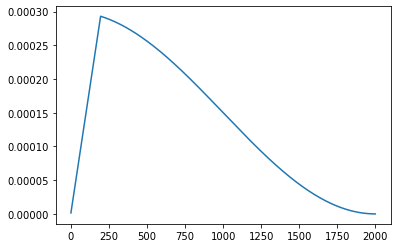

In [55]:
import matplotlib.pyplot as plt
import math


model = torch.nn.Linear(2, 1)

weight_decay = 0.05
batch_size = 512
base_lr = 1.5e-4
lr = base_lr * batch_size / 256
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)

warmup_epoch = 200
total_epoch = 2000
# optimizer = torch.optim.SGD(model.parameters(), lr=100)


lr_func = lambda epoch: min((epoch + 1) / (warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / total_epoch * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=True)
lrs = []

for i in range(total_epoch):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ",0.95," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

plt.plot(range(total_epoch),lrs)

{'state': {}, 'param_groups': [{'lr': 1.0, 'betas': (0.9, 0.95), 'eps': 1e-08, 'weight_decay': 0.05, 'amsgrad': False, 'maximize': False, 'params': [0, 1]}]}
[{'params': [Parameter containing:
tensor([[ 0.6419, -0.6922]], requires_grad=True), Parameter containing:
tensor([0.2200], requires_grad=True)], 'lr': 1.0, 'betas': (0.9, 0.95), 'eps': 1e-08, 'weight_decay': 0.05, 'amsgrad': False, 'maximize': False}]
1.0
Adjusting learning rate of group 0 to 5.0000e-03.
0.0049999999997499996
Adjusting learning rate of group 0 to 1.0000e-02.
0.009999999999499999
Adjusting learning rate of group 0 to 1.5000e-02.
0.014999999999249999
Adjusting learning rate of group 0 to 2.0000e-02.
0.019999999998999998
Adjusting learning rate of group 0 to 2.5000e-02.
0.024999999998749998
Adjusting learning rate of group 0 to 3.0000e-02.
0.029999999998499997
Adjusting learning rate of group 0 to 3.5000e-02.
0.03499999999825
Adjusting learning rate of group 0 to 4.0000e-02.
0.039999999997999997
Adjusting learning r

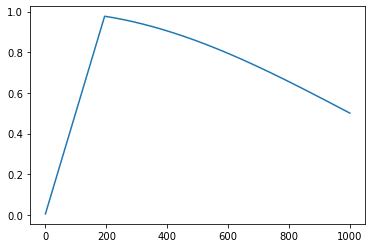

In [107]:
import matplotlib.pyplot as plt
import math


model = torch.nn.Linear(2, 1)

weight_decay = 0.05
batch_size = 256
base_lr = 1.0
lr = base_lr * batch_size / 256
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)

print(optimizer.state_dict())
print(optimizer.param_groups)
print(optimizer.param_groups[0]['lr'])

warmup_epoch = 200
total_epoch = 2000
start_epoch = 0
end_epoch = 1000
# optimizer = torch.optim.SGD(model.parameters(), lr=100)


lr_func = lambda epoch: min((epoch + 1) / (warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / total_epoch * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=True)
lrs = []

for i in range(start_epoch, end_epoch):
    optimizer.step()
    print(optimizer.param_groups[0]["lr"])
    lrs.append(optimizer.param_groups[0]["lr"])
    
#     print("Factor = ",0.95," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

plt.plot(range(start_epoch, end_epoch), lrs)

In [108]:
lrs

[0.0049999999997499996,
 0.009999999999499999,
 0.014999999999249999,
 0.019999999998999998,
 0.024999999998749998,
 0.029999999998499997,
 0.03499999999825,
 0.039999999997999997,
 0.04499999999775,
 0.049999999997499996,
 0.05499999999725,
 0.059999999996999995,
 0.06499999999674999,
 0.0699999999965,
 0.07499999999625,
 0.07999999999599999,
 0.08499999999575,
 0.0899999999955,
 0.09499999999525,
 0.09999999999499999,
 0.10499999999475,
 0.1099999999945,
 0.11499999999425,
 0.11999999999399999,
 0.12499999999375,
 0.12999999999349998,
 0.13499999999325,
 0.139999999993,
 0.14499999999274998,
 0.1499999999925,
 0.15499999999225,
 0.15999999999199999,
 0.16499999999175,
 0.1699999999915,
 0.17499999999125,
 0.179999999991,
 0.18499999999074998,
 0.1899999999905,
 0.19499999999025,
 0.19999999998999998,
 0.20499999998975,
 0.2099999999895,
 0.21499999998924998,
 0.219999999989,
 0.22499999998875,
 0.2299999999885,
 0.23499999998825,
 0.23999999998799998,
 0.24499999998775,
 0.2499999999

In [109]:
lr_scheduler.last_epoch

1000

In [110]:
optimizer_state = optimizer.state_dict()
lr_scheduler_state = lr_scheduler.state_dict()
print(optimizer_state)
print(lr_scheduler_state)


{'state': {}, 'param_groups': [{'lr': 0.5, 'betas': (0.9, 0.95), 'eps': 1e-08, 'weight_decay': 0.05, 'amsgrad': False, 'maximize': False, 'initial_lr': 1.0, 'params': [0, 1]}]}
{'base_lrs': [1.0], 'last_epoch': 1000, '_step_count': 1001, 'verbose': True, '_get_lr_called_within_step': False, '_last_lr': [0.5], 'lr_lambdas': [None]}


In [111]:
total_lrs = []
total_lrs.extend(lrs)

{'state': {}, 'param_groups': [{'lr': 0.5, 'betas': (0.9, 0.95), 'eps': 1e-08, 'weight_decay': 0.05, 'amsgrad': False, 'maximize': False, 'initial_lr': 1.0, 'params': [0, 1]}]}
[{'lr': 0.5, 'betas': (0.9, 0.95), 'eps': 1e-08, 'weight_decay': 0.05, 'amsgrad': False, 'maximize': False, 'initial_lr': 1.0, 'params': [Parameter containing:
tensor([[-0.7035, -0.0710]], requires_grad=True), Parameter containing:
tensor([0.4564], requires_grad=True)]}]
0.5
Adjusting learning rate of group 0 to 5.0000e-01.
Adjusting learning rate of group 0 to 4.9921e-01.
Adjusting learning rate of group 0 to 4.9843e-01.
Adjusting learning rate of group 0 to 4.9764e-01.
Adjusting learning rate of group 0 to 4.9686e-01.
Adjusting learning rate of group 0 to 4.9607e-01.
Adjusting learning rate of group 0 to 4.9529e-01.
Adjusting learning rate of group 0 to 4.9450e-01.
Adjusting learning rate of group 0 to 4.9372e-01.
Adjusting learning rate of group 0 to 4.9293e-01.
Adjusting learning rate of group 0 to 4.9215e-0

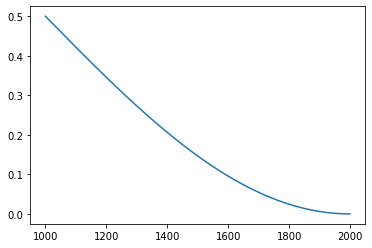

In [112]:
import matplotlib.pyplot as plt
import math

model = torch.nn.Linear(2, 1)

weight_decay = 0.05
batch_size = 256
# base_lr = 1.5e-4
# lr = base_lr * batch_size / 256
lr = lr_scheduler_state['_last_lr'][-1]
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)
optimizer.load_state_dict(optimizer_state)

print(optimizer.state_dict())
print(optimizer.param_groups)
print(optimizer.param_groups[0]['lr'])


warmup_epoch = 200
total_epoch = 2000
start_epoch = 1000
end_epoch = 2000
# optimizer = torch.optim.SGD(model.parameters(), lr=100)


lr_func = lambda epoch: min((epoch + 1) / (warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / total_epoch * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=True, last_epoch=start_epoch-1)
lrs = []
# lr_scheduler.load_state_dict(lr_scheduler_state)

for i in range(start_epoch, end_epoch):
    
    
    lrs.append(optimizer.param_groups[0]["lr"])
    optimizer.step()
#     print("Factor = ",0.95," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

plt.plot(range(start_epoch, end_epoch),lrs)

In [113]:
lrs


[0.5,
 0.49921460215958463,
 0.4984292062570602,
 0.49764381423031334,
 0.4968584280172205,
 0.4960730495556445,
 0.495287680783428,
 0.49450232363839103,
 0.49371698005832365,
 0.49293165198098376,
 0.49214634134408974,
 0.49136105008531783,
 0.49057578014229597,
 0.4897905334525999,
 0.48900531195374747,
 0.488220117583195,
 0.4874349522783313,
 0.4866498179764739,
 0.4858647166148634,
 0.4850796501306596,
 0.48429462046093585,
 0.483509629542675,
 0.48272467931276386,
 0.48193977170798946,
 0.4811549086650327,
 0.48037009212046583,
 0.479585324010745,
 0.47880060627220805,
 0.47801594084106763,
 0.47723132965340787,
 0.4764467746451787,
 0.4756622777521919,
 0.47487784091011526,
 0.47409346605446895,
 0.4733091551206198,
 0.4725249100437772,
 0.47174073275898776,
 0.47095662520113113,
 0.4701725893049147,
 0.4693886270048691,
 0.4686047402353433,
 0.4678209309305002,
 0.46703720102431107,
 0.4662535524505519,
 0.4654699871427971,
 0.4646865070344168,
 0.46390311405856965,
 0.4631198

In [114]:
total_lrs.extend(lrs)

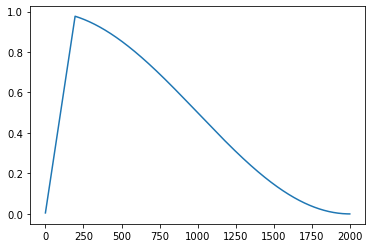

In [115]:
plt.plot(total_lrs)

In [58]:
for i in range(start_epoch, end_epoch):
    print(i)

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


In [ ]:
torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=True)

In [38]:
torch.optim.lr_scheduler.LambdaLR()

TypeError: __init__() missing 2 required positional arguments: 'optimizer' and 'lr_lambda'